In [112]:
#!/usr/bin/python3

import os
import string
import threading
from queue import Queue
import time
import pandas as pd
import numpy as np
from typing import List
from websocket import create_connection
import socket
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce, OrderStatus
from alpaca.trading.requests import LimitOrderRequest
from alpaca.trading.requests import GetOrdersRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest

from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from ta.trend import VortexIndicator
from ta.volatility import BollingerBands
import time
import datetime as dt

In [113]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest
api  = 'PK8AWLHHM9R99WPKQ73I'
secret = 'ACdKis9STB3paVP7H3NoBdMSxmMofUKQQXAE2aNa'
# keys required for stock historical data client
client = StockHistoricalDataClient(api,secret)


In [114]:
from alpaca.data import StockBarsRequest

start_date = dt.date.today() - dt.timedelta(days=365)
start_date = dt.datetime.combine(start_date, dt.datetime.min.time())
end_date = dt.date.today()
end_date = dt.datetime.combine(end_date, dt.datetime.min.time())

request_params = StockBarsRequest(
    symbol_or_symbols=['AAPL'],  # Can be a list of symbols or a single symbol ['AAPL', 'TSLA'] or 'AAPL'
    timeframe=TimeFrame.Hour,
    start=start_date,


)

data = client.get_stock_bars(request_params)
data = data.df
data = data.reset_index(pd.Index(['symbol']))
data

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-10-18 08:00:00+00:00,AAPL,144.390,144.39,144.04,144.2500,24003.0,587.0,144.249573
2021-10-18 09:00:00+00:00,AAPL,144.210,144.40,144.16,144.3200,16470.0,331.0,144.241228
2021-10-18 10:00:00+00:00,AAPL,144.280,144.32,144.00,144.2000,26060.0,486.0,144.157169
2021-10-18 11:00:00+00:00,AAPL,144.270,144.89,144.25,144.6400,212303.0,2398.0,144.640447
2021-10-18 12:00:00+00:00,AAPL,144.600,144.64,144.00,144.1500,2311003.0,4328.0,144.743503
...,...,...,...,...,...,...,...,...
2022-10-17 12:00:00+00:00,AAPL,140.380,141.20,140.21,141.0497,468428.0,6728.0,140.778494
2022-10-17 13:00:00+00:00,AAPL,141.050,142.69,140.49,142.0000,14906657.0,149213.0,141.849901
2022-10-17 14:00:00+00:00,AAPL,142.005,142.22,140.71,140.9772,14319724.0,112552.0,141.675800


In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['close'], model='additive', period=356)
# extract the trend, seasonal, and residual components
data['trend'] = decomposition.trend
data['seasonal'] = decomposition.seasonal
data['residual'] = decomposition.resid
data['rsi'] = RSIIndicator(data.close, 14).rsi()


# calculate the mean of the residuals and the standard deviation of the residuals to check for outliers in the data set
residual_mean = data.residual.mean()
residual_std = data.residual.std()
min_seasonal_degree =  data.seasonal.min()
max_seasonal_degree =  data.seasonal.max()

percent_val = (0.01*abs(min_seasonal_degree))

lowerband = min_seasonal_degree+percent_val
upperband = max_seasonal_degree-percent_val

# buy signal
data['signal']=''

data['signal'] = np.where((data['seasonal']<lowerband) & (data['seasonal'].shift(0)<lowerband)
                          & (data['signal'].shift(1)!=1)
                         & (data.rsi>=10)
                            , 1, 0)
# sell signal
data['signal'] = np.where((data['seasonal']>upperband)& (data['seasonal'].shift(1)>lowerband)
                          & (data['signal'].shift(1)!=-1)
                              & (data.rsi<70)
                              , -1, data['signal'])



# creating positions


data['position_1'] = data['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
data['position_1'] = data['position_1'].shift(1)
data["bnh_returns"] = np.log(data["close"]/data["close"].shift())

data['strategy_returns'] = data['bnh_returns'] * (data['position_1'])


# calculating stretegy returns
data

,symbol,open,high,low,close,volume,trade_count,vwap,trend,seasonal,residual,rsi,signal,position_1,bnh_returns,strategy_returns
timestamp,,,,,,,,,,,,,,,,
2021-10-18 08:00:00+00:00,AAPL,144.390,144.39,144.04,144.2500,24003.0,587.0,144.249573,NaN,-1.110858,NaN,NaN,0,NaN,NaN,NaN
2021-10-18 09:00:00+00:00,AAPL,144.210,144.40,144.16,144.3200,16470.0,331.0,144.241228,NaN,-1.241778,NaN,NaN,0,0.0,0.000485,0.000000
2021-10-18 10:00:00+00:00,AAPL,144.280,144.32,144.00,144.2000,26060.0,486.0,144.157169,NaN,-1.095293,NaN,NaN,0,0.0,-0.000832,-0.000000
2021-10-18 11:00:00+00:00,AAPL,144.270,144.89,144.25,144.6400,212303.0,2398.0,144.640447,NaN,-0.699273,NaN,NaN,0,0.0,0.003047,0.000000
2021-10-18 12:00:00+00:00,AAPL,144.600,144.64,144.00,144.1500,2311003.0,4328.0,144.743503,NaN,-0.963472,NaN,NaN,0,0.0,-0.003393,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17 12:00:00+00:00,AAPL,140.380,141.20,140.21,141.0497,468428.0,6728.0,140.778494,NaN,-0.240403,NaN,56.230514,0,1.0,0.004831,0.004831
2022-10-17 13:00:00+00:00,AAPL,141.050,142.69,140.49,142.0000,14906657.0,149213.0,141.849901,NaN,-0.347951,NaN,60.837969,0,1.0,0.006715,0.006715
2022-10-17 14:00:00+00:00,AAPL,142.005,142.22,140.71,140.9772,14319724.0,112552.0,141.675800,NaN,0.031561,NaN,54.222184,0,1.0,-0.007229,-0.007229


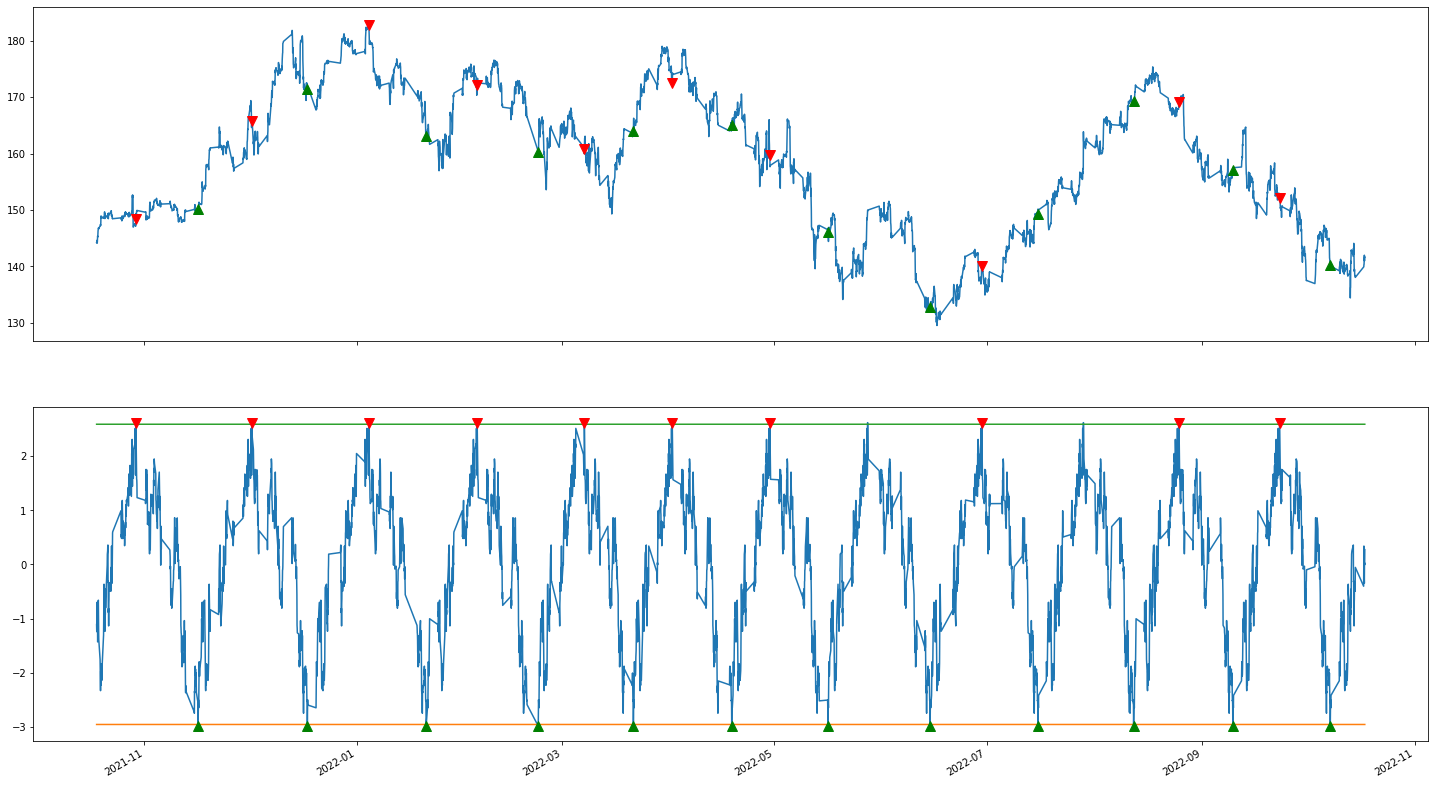

In [116]:
# plot the buy and sell signals on the close price series
from matplotlib import pyplot as plt

plt.figure(figsize=(25,15))
plt.subplot(2,1,1)
plt.plot(data['close'], label='Close',linewidth=1.5 )
# plot the buy points on the close price series
plt.plot(data.signal.loc[data.signal == 1].index, data['close'][data.signal == 1], '^', markersize=10, color='g', label='Buy')
# plot the sell points on the close price series
plt.plot(data.signal.loc[data.signal == -1].index, data['close'][data.signal == -1], 'v', markersize=10, color='r', label='Sell')
# plot the no signal points on the close price series
#plt.plot(df.signal.loc[df.signal == 0].index, df['Adj Close'][df.signal == 0], '.', markersize=2, color='k', label='No Signal/ Hold')
plt.gcf().autofmt_xdate()


plt.subplot(2,1,2)
plt.plot(data.seasonal, label='Seasonality')
plt.plot(data.seasonal.index, lowerband*np.ones(len(data.seasonal)), label='Lower Bound')
plt.plot(data.seasonal.index, upperband*np.ones(len(data.seasonal)), label='Upper Bound')
 # plot the buy points on the close price series
plt.plot(data.signal.loc[data.signal == 1].index, data['seasonal'][data.signal == 1], '^', markersize=10, color='g', label='Up')
plt.plot(data.signal.loc[data.signal == -1].index, data['seasonal'][data.signal == -1], 'v', markersize=10, color='r', label='Down')
plt.gcf().autofmt_xdate()

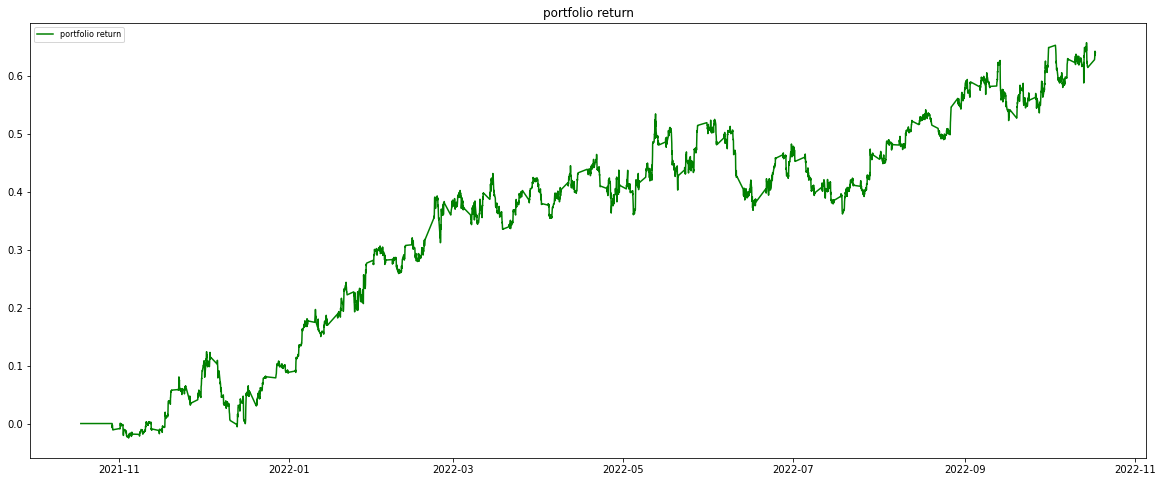

In [117]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
plt.plot(data['strategy_returns'].cumsum(), label='portfolio return', color = 'green',)
plt.title(f"portfolio return")


plt.legend(loc='upper left', fontsize=8)
plt.show()